# Document AI : Results Schema

### Prerequisites

In [20]:
# !sudo apt-get install -y poppler-utils # need for pdfinfo command

In [24]:
!cat requirements.txt

google-cloud-documentai==0.4.0
google-cloud-bigquery==2.13.1
pdf2image==1.14.0
ipyplot==1.1.0
Wand==0.6.6

In [25]:
# !pip install -r requirements.txt

In [26]:
from google.cloud import documentai_v1beta3 as documentai
from google.cloud import bigquery
from wand.image import Image as WImage
import pandas as pd

PROJECT_ID = 'doc-ai-ce'

PROCESSOR_ID = 'e38c82311d145f3b'
# f1004 = edf8ed12c7755ea6
# f1040 = 75e363734cdaed76
# invoice = e38c82311d145f3b

LOCATION = 'us'

# Download Invoice

##### <i> More Sample Invoices: https://github.com/GoogleCloudPlatform/documentai-notebooks/tree/master/resources/procurement/invoices

In [27]:
!mkdir -p pdf_samples
# !gsutil cp gs://cloud-samples-data/documentai/* ./pdf_samples/
INVOICE_PDF = './pdf_samples/fake_invoice.pdf'

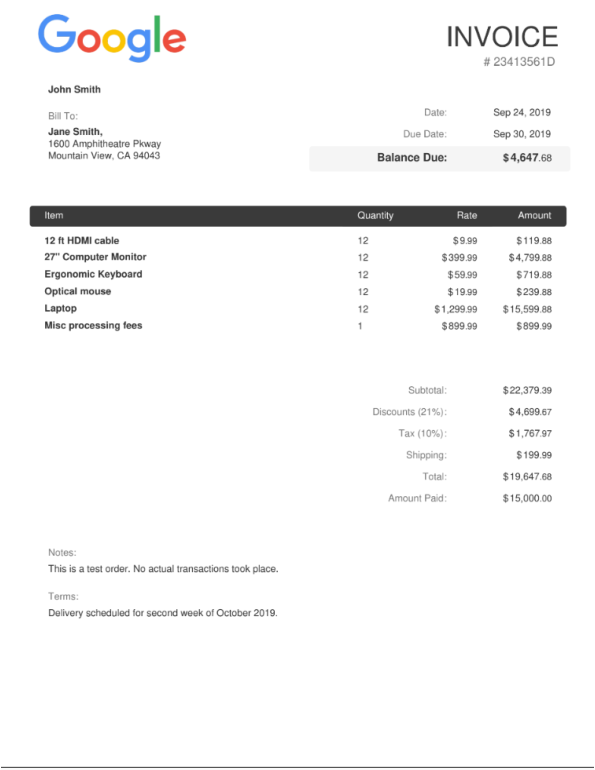

In [28]:
WImage(filename=INVOICE_PDF, resolution=70)

# Process Invoice

### 1. Call Document AI

In [30]:
%%time

processor_name = f'projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}'

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [31]:
%%time

with open(INVOICE_PDF, 'rb') as image:
    document = {'content': image.read(), 'mime_type': 'application/pdf'}
    request = {'name': processor_name, 'document': document}

CPU times: user 446 µs, sys: 658 µs, total: 1.1 ms
Wall time: 575 µs


In [32]:
%%time

results = documentai.DocumentProcessorServiceClient().process_document(request=request)

KeyboardInterrupt: 

### 2. Display Results Schema

In [17]:
results

NameError: name 'results' is not defined

### 3. Gather Entities

In [7]:
results_frame = [[entity.type_, entity.mention_text, round(entity.confidence, 4)] for entity in results.document.entities]
df = pd.DataFrame(results_frame, columns=['type', 'value','confidence'])
df

,type,value,confidence
0,invoice_date,"Sep 24, 2019",0.9934
1,due_date,"Sep 30, 2019",0.9911
2,total_amount,"19,647.68",0.9695
3,total_tax_amount,"$1,767.97",0.9227
4,net_amount,"22,379.39",0.9070
5,receiver_name,"Jane Smith,",0.8333
6,invoice_id,23413561D,0.6679
7,receiver_address,"1600 Amphitheatre Pkway\nMountain View, CA 94043",0.6601
8,freight_amount,$199.99,0.5551
9,currency,$,0.5278


### 4. Transform Data

In [8]:
df_t = df.rename(columns={'type':'index'}).drop(columns=['confidence']).T
df_t.columns = df_t.iloc[0]
df_t = df_t.drop(df_t.index[0])
df_t = df_t.reset_index(drop=True) 

df_t = df_t[['invoice_id','purchase_order','due_date'] + [col for col in df_t.columns if '_amount' in col]]

# transform date column
df_t['due_date'] = pd.to_datetime(df_t['due_date'])

# transform amount columns
for num_col in [col for col in df_t.columns if '_amount' in col]:
    df_t[num_col] = pd.to_numeric(df_t[num_col].replace({'\$':'', ',':''}, regex = True))

keeper_cols = ['invoice_id', 'purchase_order', 'due_date', 'total_tax_amount', 'freight_amount', 'net_amount', 'total_amount']
    
df_t = df_t[keeper_cols]
df_t

index,invoice_id,purchase_order,due_date,total_tax_amount,freight_amount,net_amount,total_amount
0,23413561D,23413561D,2019-09-30,1767.97,199.99,22379.39,19647.68


# Another Invoice  

### Now process and save another invoice, all at once.

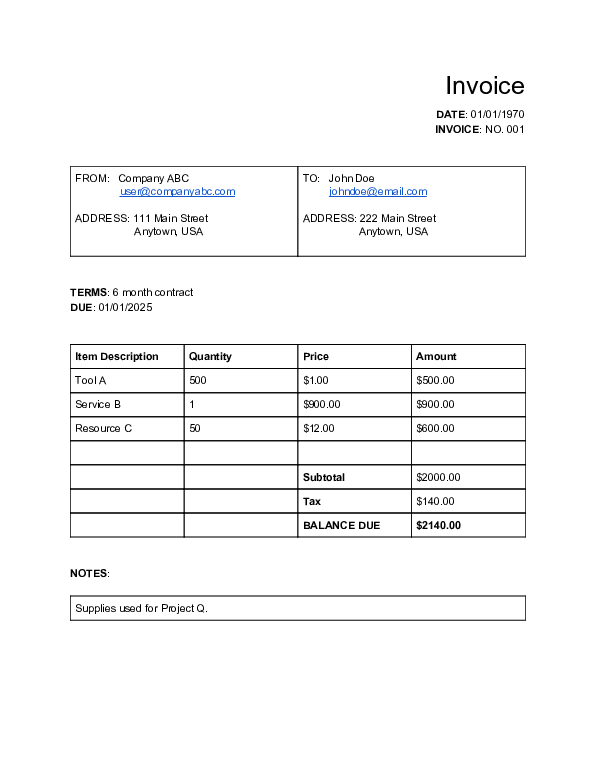

In [13]:
INVOICE_PDF = './pdf_samples/invoice.pdf'
WImage(filename=INVOICE_PDF, resolution=70)

In [14]:
with open(INVOICE_PDF, 'rb') as image:
    document = {'content': image.read(), 'mime_type': 'application/pdf'}
    request = {'name': processor_name, 'document': document}    

results = documentai.DocumentProcessorServiceClient().process_document(request=request)
results_frame = [[entity.type_, entity.mention_text, round(entity.confidence, 4)] for entity in results.document.entities]
df = pd.DataFrame(results_frame, columns=['type', 'value','confidence'])
df

,type,value,confidence
0,invoice_date,01/01/1970,0.9942
1,due_date,01/01/2025,0.9930
2,payment_terms,6 month contract,0.9390
3,total_tax_amount,$140.00,0.9394
4,net_amount,2000.00,0.9261
5,receiver_name,John Doe,0.9263
6,total_amount,2140.00,0.7384
7,supplier_name,Company ABC,0.6800
8,receiver_address,"222 Main Street\nAnytown, USA",0.6294
9,currency,$,0.6019


In [15]:
df_t = df.rename(columns={'type':'index'}).drop(columns=['confidence']).T
df_t.columns = df_t.iloc[0]
df_t = df_t.drop(df_t.index[0])
df_t = df_t.reset_index(drop=True) 

df_t = df_t[['invoice_id','purchase_order','due_date'] + [col for col in df_t.columns if '_amount' in col]]

# transform date column
df_t['due_date'] = pd.to_datetime(df_t['due_date'])

# transform amount columns
for num_col in [col for col in df_t.columns if '_amount' in col]:
    df_t[num_col] = pd.to_numeric(df_t[num_col].replace({'\$':'', ',':''}, regex = True))
    
df_t

index,invoice_id,purchase_order,due_date,total_tax_amount,net_amount,total_amount,freight_amount,vat/tax_amount
0,NO. 001,001,2025-01-01,140.0,2000.0,2140.0,600.0,140.0


In [16]:
bq.insert_rows_from_dataframe(table=f'{DATASET}.{TABLE}', dataframe=df_t, selected_fields = schema)

[[]]

In [17]:
bq.query(f'''
    SELECT 
        invoice_id,
        purchase_order, 
        cast(due_date AS DATE) due_date,
        net_amount,
        total_amount,
        total_tax_amount,
        freight_amount
    FROM 
        {DATASET}.{TABLE}''').to_dataframe()

,invoice_id,purchase_order,due_date,net_amount,total_amount,total_tax_amount,freight_amount
0,23413561D,23413561D,2019-09-30,22379.39,19647.68,1767.97,199.99


# Check Directly in BigQuery UI

<img src='imgs/bq_query.png' width=1200/>